# Setup
code for setting up imports and database


imports


In [1]:
#imports all functions and packages i will use

import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

import skimage.util as util 

from skimage.exposure import rescale_intensity
import skimage.io as ski
from skimage.feature import match_template

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import imutils
import statistics as st
#import pandas as pd
import sqlite3 as sl
from functools import reduce
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv # image processing algorithms

drive mount

In [ ]:
from google.colab import drive
#connects to drive for my folders
drive.mount('/content/drive')
path = '/content/drive/MyDrive/mv/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data base for the colours rgb and hsv values

In [ ]:
global con
con = sl.connect('colours.db')
#creats a database for colours boundaries to be used in program, can be chanegd if found different boundries
with con: # makes the table
    con.execute("""
      CREATE TABLE USER (
            name TEXT,
            rgb1 INTEGER,
            rgb2 INTEGER,
            rgb3 INTEGER,
            hsv1 INTEGER,
            hsv2 INTEGER,
            hsv3 INTEGER,
            LHSV1 INTEGER,
            LHSV2 INTEGER,
            LHSV3 INTEGER,
            UHSV1 INTEGER,
            UHSV2 INTEGER,
            UHSV3 INTEGER
        );
      """)

sql = 'INSERT INTO USER (name, rgb1, rgb2, rgb3, hsv1, hsv2, hsv3, LHSV1, LHSV2, LHSV3, UHSV1, UHSV2, UHSV3) values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'
data = [ #adds data into table
    ('green', 0, 255, 0, 60, 255, 255, 50, 200, 200, 70, 255, 255),
    ('red', 255, 0, 0, 120, 255, 255, 110, 200, 200, 130, 255, 255),
    ('blue', 0, 0, 255, 0, 255, 255, 0, 200, 200, 10, 255, 255),
    ('black', 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10),
    ('brown', 162, 42, 42, 120, 189, 162, 110, 140, 100, 130, 189, 162),
    ('orange', 255, 165, 0, 101, 255, 255, 91, 200, 200, 111, 255, 255),
    ('yellow', 255, 255, 0, 90, 255, 255, 80, 200, 200, 100, 255, 255),
    ('purple', 128, 0, 128, 150, 255, 128, 140, 200, 78, 160, 255, 128),
    ('grey', 128, 128, 128, 0, 0, 128, 0, 0, 118, 10, 10, 128),
    ('white', 255, 255, 255, 0, 0, 255, 0, 0, 235, 10, 10, 255),
    ('gold', 255, 215, 0, 95, 255, 255, 85, 200, 200, 105, 255, 255),
    #('silver', 192, 192, 192, 0, 0, 192, 0, 0, 182, 10, 10, 202),  # found was coming off the metal pins
    #('dark_red', 139, 0, 0, 120, 255, 139, 110, 100, 0, 130, 255, 139) wasn't needed
]

with con:
    con.executemany(sql, data)

# Functions 


find colour binds
prints are inside for debugging

In [ ]:
#from matplotlib.cbook import contiguous_regions
def find_colours(img):
  colour_cords = []
  with con:
    data = con.execute("SELECT * FROM USER")
  #iteration to check for bands for each colour
  for row in data :
    #converst image from rgb to hsv
   # cv2_imshow( img)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

   # print(row[0])
   #creates the arrays for the colour areas we want that will match the area
    lower = np.array([row[7], row[8], row[9]])
    upper = np.array([row[10],row[11], row[12]])

    #mask = cv2.inRange(img_hsv,lower,upper)
   # cv2_imshow( img)
    #cv2_imshow( mask)
    
    # create a structuring element
    kernel = np.ones((5,5),np.uint8)
    # closing
    closing = cv2.morphologyEx(img_hsv, cv2.MORPH_CLOSE, kernel, iterations=4)

    # erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(13,13))
    erosion = cv2.erode(closing,kernel,iterations = 1)
    #cv2_imshow(erosion)
    #erodes the image so colours are more clear

    #creates the mask that finds the band with the black and whits
    mask = cv2.inRange(erosion, lower, upper)
      
    # Display Image and Mask
    #cv2_imshow( img)
    #cv2_imshow( mask)

    #creates the lables at center of mass which in this case is the bands
    labels, nlabels = ndimage.label(mask)
    centroid = ndimage.center_of_mass(mask, labels, np.arange(nlabels) + 1 ) # calculate the center of mass of the values of an array at labels.

    #puts the data into an interation to get each seperate band
    
    #print(row[0])
    x = 0
    for cen2 in centroid:
      Colour = [[],[]] # for the colour and x cord
      #display = cv2.circle(image, (cen2[1].astype(int), cen2[0].astype(int)), radius=10, color=(255, 255, 255), thickness=-1) for debugging visualises bands on resistors
      try:#needs to be a try as first if is always impossible
        
        if ((cen2[0] - colour_cords[x][1]) < 50 ) and ((cen2[0] - colour_cords[x][1]) > -50 ) : # this makes sure no repeat bands were court
          #print("x")
          continue
        else:
          Colour[0].append(row[0])
          Colour[1].append(cen2[0])
          colour_cords.append(Colour) # adds coulour and cord to the array for use in the resistor value function
          #print(colour_cords[x][1])
          x = x + 1 # ensure it continues through the list
          continue
      except:
        Colour[0].append(row[0])
        Colour[1].append(cen2[0])
        colour_cords.append(Colour)

    #cv2_imshow(display) for debug

    
  return(colour_cords)



detect image functio

In [ ]:
global detections
detections = []

def Resdetection(image):

  for i in range(len(template)): # runs 360 times, 1 for each degree to be accurate
    rectss = [] #this gets the area square where resistor is for cropping to help limit colours in the band part of the program
    check = template[i] # loads 1

    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = denoise(image) # sharpens the image
    found = None
      # loop over the scales of the image
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
      resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
      r = gray.shape[1] / float(resized.shape[1])
        # if the resized image is smaller than the template, then break
        # from the loop
      if resized.shape[0] < tH or resized.shape[1] < tW:
        break


        # detect edges in the resized, grayscale image and apply template
        # matching to find the template in the image
      edged = cv2.Canny(resized, 50, 200) # makes image edges to help with accuracy
      result = cv2.matchTemplate(edged, check, cv2.TM_CCOEFF) #the command that matches the image
      (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
        # check to see if the iteration should be visualized
        #if args.get("visualize", False):
#gets the cords for cropping
      if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)
      #print(maxLoc[0])
      try:
        rectt = rect(maxLoc[0], maxLoc[1], r)     
        rectss.append(rectt)
      except:
        #print("f")
        pass
  area = Get_Found_area(rectss)
  imgdraw = image
  #cv2.rectangle(imgdraw, (area[0], area[1]), (area[2], area[3]), (0, 0, 255), 2)debug 
  #cv2.rectangle(imgdraw, (area[4], area[5]), (area[6], area[7]), (0, 255, 0), 2)debug
  f = 0

  #this checks if a resistor was found or not a 5 is what is return in get found area if it didn't have values
  for i in area:
    if i == 5:
      f = f+1

  if f == 4:
    return
  else:
    
    # dim = (128, 128)

    img_cropped = image[area[0]:area[2], area[1]:area[3], :] # cropps image
    #cv2_imshow(imgdraw)
    #cv2_imshow(img_cropped)
    detections.append(img_cropped) # appends the image to detections to show we have a resistor



class and function for getting the squares avg for detect resistor

In [ ]:

#class for storing data of the cords of the matches
class rect:
  def __init__(self, ml1 ,ml2, r):
    self.ml1 = ml1
    self.ml2 = ml2
    self.r = r

def Get_Found_area(rectss):
  #lists used in function
  Left_corner_x = []
  Left_corner_y = []
  Right_corner_x = []
  Right_corner_y = []
  final_cords = []
  #gathers info and puts them into arrays
  #gathers the cords that were all gathered and puts them in seperate lists
  for i in range(len(rectss)):
    startx = int(rectss[i].ml1 * rectss[i].r)
    starty = int(rectss[i].ml2 * rectss[i].r)
    endx = int((rectss[i].ml1 + tW) * rectss[i].r)
    endy = int((rectss[i].ml2 + tW) * rectss[i].r)

    Left_corner_x.append(startx)
    Left_corner_y.append(starty)
    Right_corner_x.append(endx)
    Right_corner_y.append(endy)
    #print(startx)
  #trys to sort the list and removes outliers, uses try cause they could have 0 and not work
  try:
    Left_corner_x = sort_remove(Left_corner_x)
    Left_corner_y = sort_remove(Left_corner_y)
    Right_corner_x = sort_remove(Right_corner_x)
    Right_corner_y = sort_remove(Right_corner_y)
  except:
    pass
  """
  try:
    final_cords.append(int(sum(Left_corner_x)/len(Left_corner_x)))
  except:
    final_cords.append(5)
  try:
    final_cords.append(int(sum(Left_corner_y)/len(Left_corner_y)))
  except:
    final_cords.append(5)
  try:
    final_cords.append(int(sum(Right_corner_x)/len(Right_corner_x)))
  except:
    final_cords.append(5)
  try:  
    final_cords.append(int(sum(Right_corner_y)/len(Right_corner_y)))
  except:
    final_cords.append(5)
    """

    #this is done as  top left wants to be small as the cv2 images have 0 in top corner, and so wants to be smallest value, and right corner is the reverse for that it needs to be the biggest as furtherst away
  try:
    final_cords.append(reduce(min,Left_corner_x)) # min x for resistor detected for crop
  except:
    final_cords.append(5)
  try:
    final_cords.append(reduce(min,Left_corner_y))# min y for resistor detected for crop
  except:
    final_cords.append(5)
  try:
    final_cords.append(reduce(max,Right_corner_x))# max x for resistor detected for crop
  except:
    final_cords.append(5)
  try:  
    final_cords.append(reduce(max,Right_corner_y))# max y for resistor detected for crop
  except:
    final_cords.append(5)


  return final_cords
  

an easy bubblesort

In [ ]:
#https://www.geeksforgeeks.org/python-program-for-bubble-sort/
#simple bubble sort, got it from here^^

def bubbleSort(arr):
  n = len(arr)

	# Traverse through all array elements
  for i in range(n-1):
	# range(n) also work but outer loop will
	# repeat one time more than needed.

		# Last i elements are already in place
    for j in range(0, n-i-1):

			# traverse the array from 0 to n-i-1
			# Swap if the element found is greater
			# than the next element
      if arr[j] > arr[j + 1] :
        arr[j], arr[j + 1] = arr[j + 1], arr[j]
  return(arr)





removes outliers form detection arrays

In [ ]:
def removeoutliers(arr):
 # n = len(arr)
  med = (st.median(arr)) #gets median
  Q1 = []
  Q3 = []

  for i in range(len(arr)):
    if (arr[i] < med):
      Q1.append(arr[i]) # splits list in half to get teh 2 quartiles
      #print(arr[i])
    elif (arr[i] > med):
      Q3.append(arr[i])
      #print(arr[i])
  
 # n = len(Q1)
  medQ1 = (st.median(Q1)) # gets median of Q1
  #n = len(Q3)
  #print(medQ1)
  
  medQ3 = (st.median(Q3)) # gets median of Q3
  #print(medQ3)
  IQR = medQ3 - medQ1 # finds inter quartile range
  lf = medQ1 - (0.5* IQR) #  i use 0.5 for accuracy aas that seems to work well in removing outliers, any bigger won't find any outliers
  uf = medQ3 + (0.5* IQR)
  #print(lf)
  #print(uf)
  out_gone = [] # the new list without outliers gone

  for i in range(len(arr)):
    if (arr[i] >= lf) and (arr[i] <= uf):
      out_gone.append(arr[i])
      #print(arr[i] + "g")
  return(out_gone)

# Driver code to test above


def sort_remove(arr):# runs the bubble sort before the ranges as needs to be sorted before it can do that
  t = bubbleSort(arr)
  x = removeoutliers(t)

  return(x)


denoises images

In [ ]:
def denoise(image) :

  #simple function to sharp image edges
  grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #  add salt and pepper noise
  grey_sp = util.random_noise(grey, 's&p', clip=True)

  #  results returned was scaled between 0 and 1. Change it to 0 and 255
  grey_sp = (grey_sp*255).astype(np.uint8)
  # denoises image to be sharper for edges when applied
  med_denoised = ndimage.median_filter(grey_sp, 5)
  #cv2_imshow(med_denoised)
  return(med_denoised)

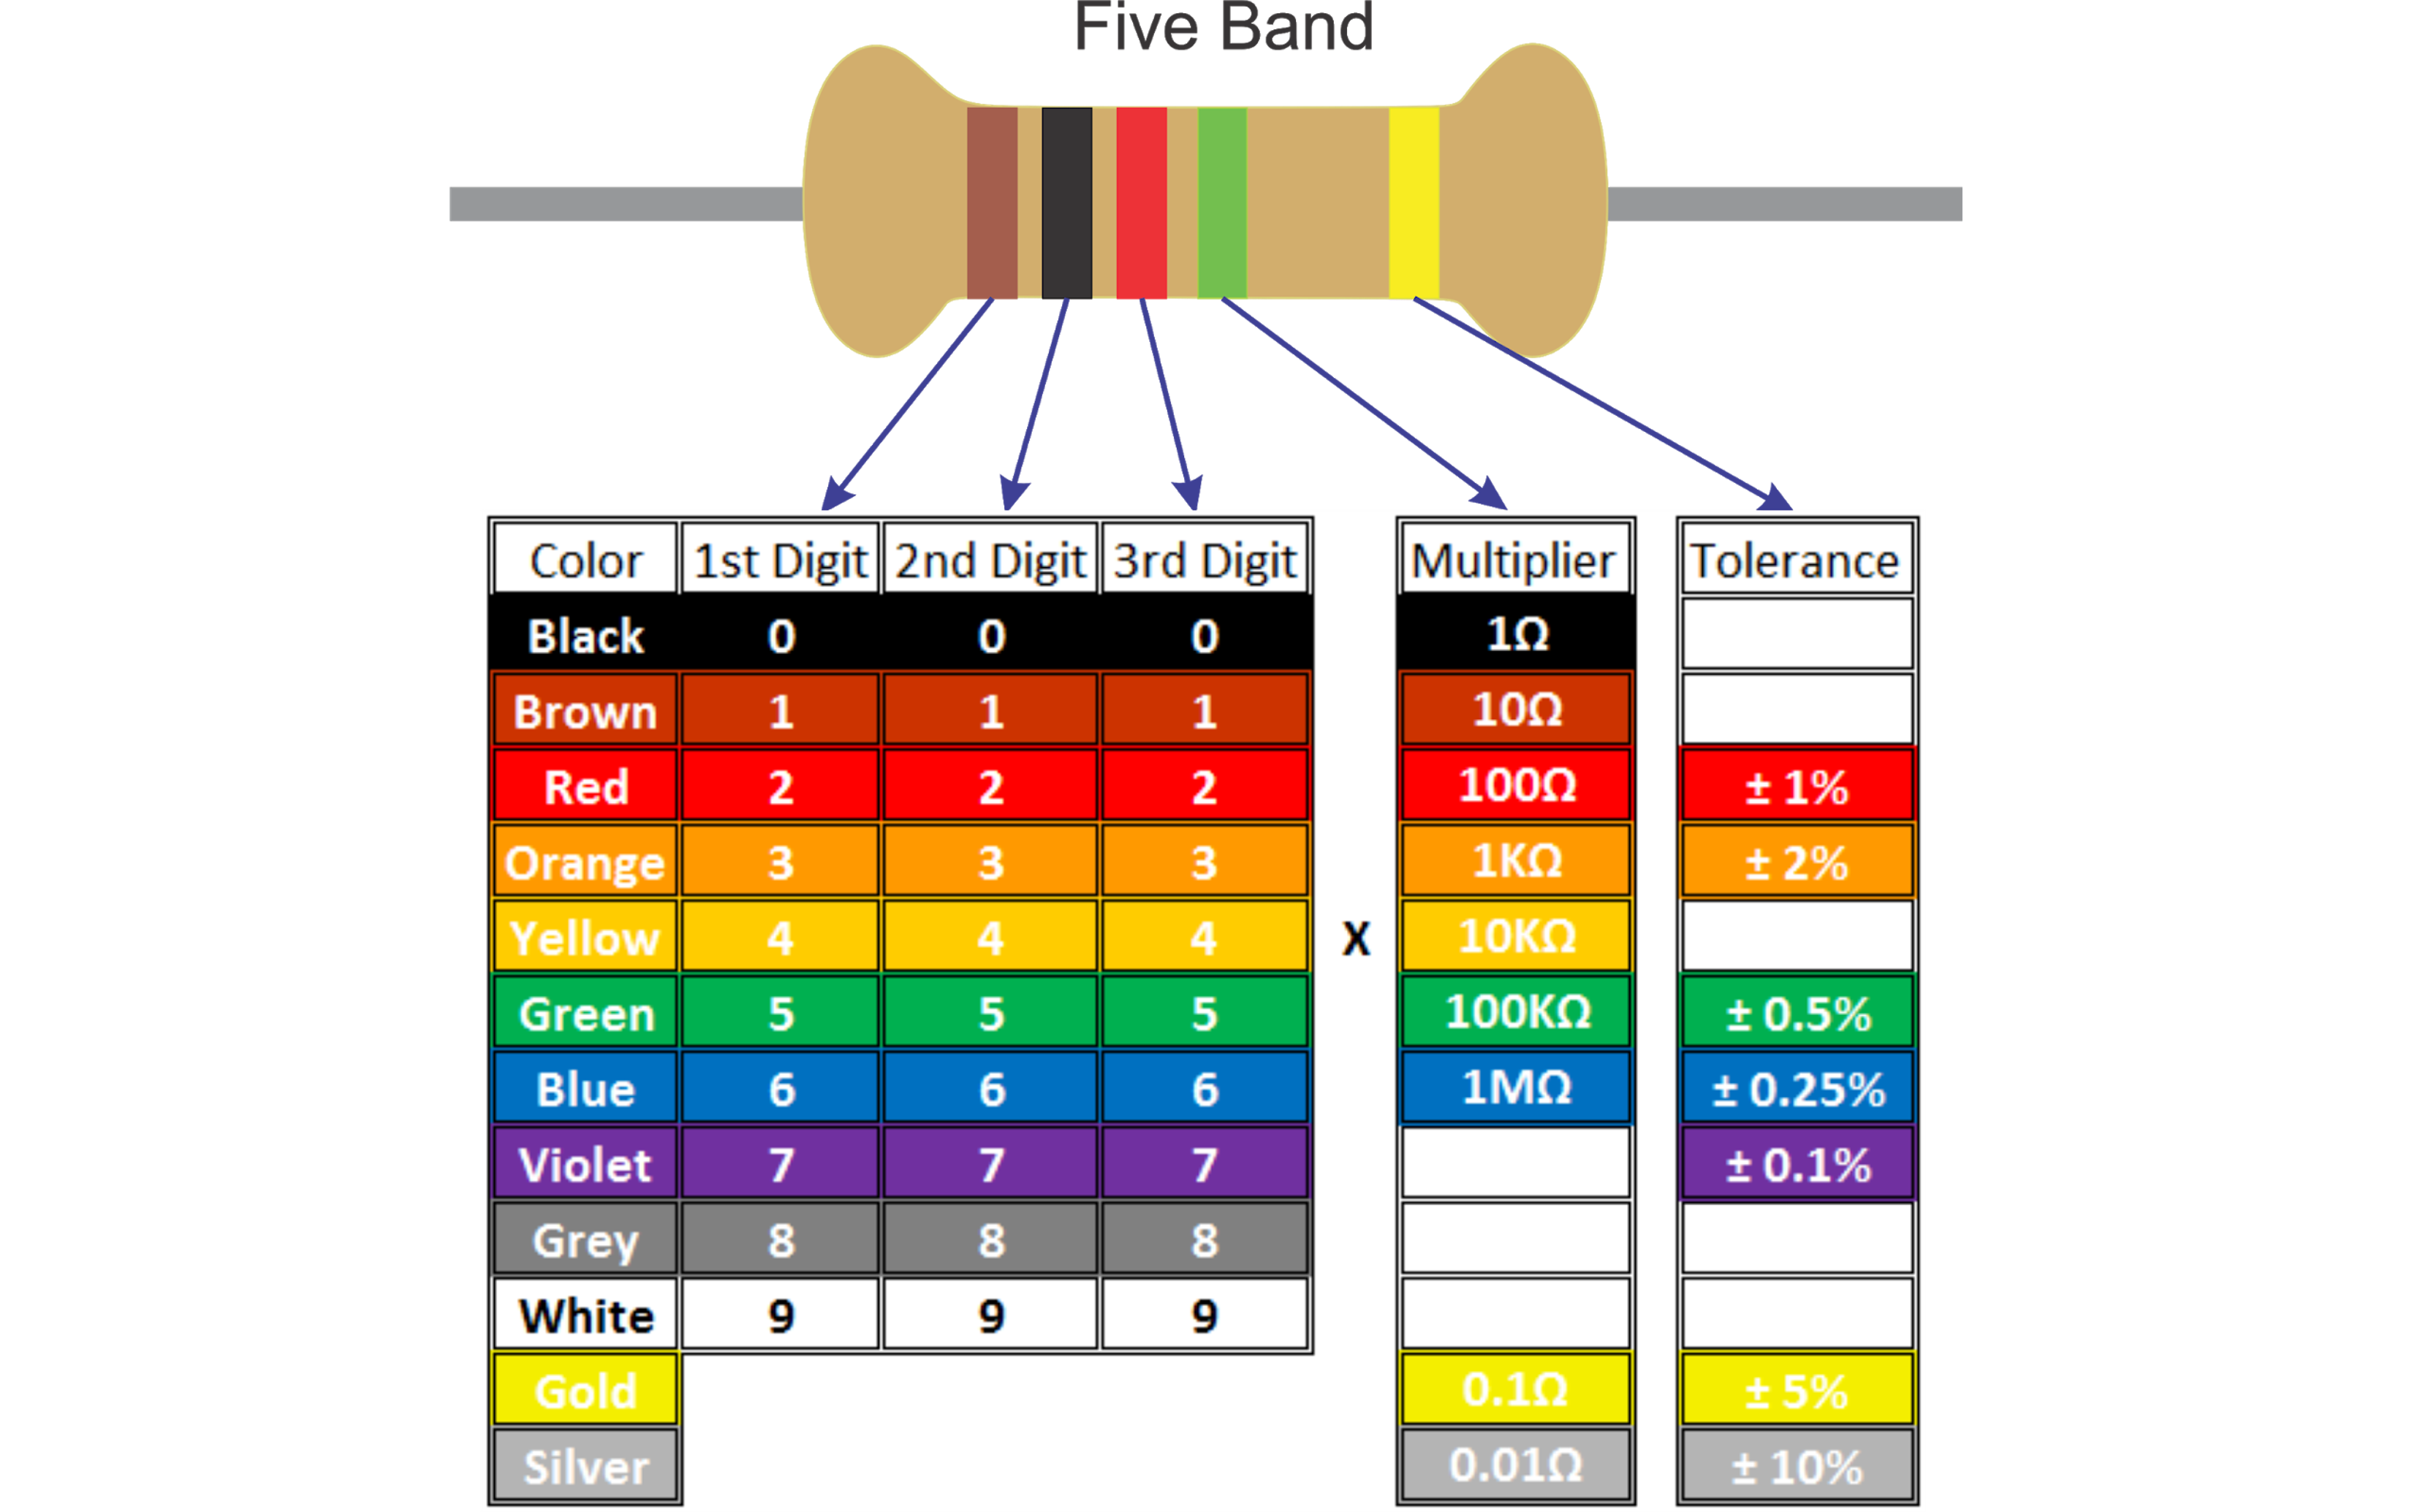

In [ ]:
def resistor_value(C):
  c = C
  # a bubble sort to order the colours from left to right
  #using the x values of the labels
  n = len(C)
  a = 0
 # print(C)
 #removes any colours from the list that weren't found
  for i in range(n):
    #print(i)
    if (C[i - a ][1]) == [[]]:
      #print('f')
      c.pop(i - a) 
      #print(c)
      a = a+1
  n = len(c)
  #print(c)
  # a bubble sort to order the colours from left to right
  for i in range(n-1):

		# Last i elements are already in place
    for j in range(0, n-i-1):

      if c[j][1] > c[j+1][1] :
        c[j], c[j + 1] = c[j + 1], c[j]
  """ a = 0
  x = c
  print(c)
  for i in range(n):
    #print(i)
    if (c[i - a ][1]) == (c[i - a +1][1]):
      #print('f')
      x.pop(i - a) 
      #print(c)
      a = a+1
"""
  #print(c)
 # gets the first digit of the resistor value
  #print(c)
  #print(c[0][0])
  a = 0
  #gold broke the code if 2 early and some how got seen as red sometimes
  for i in range(len(c)):
    if c[i - a][0] == ['gold']:
      if i < 5 :
        c.pop(i - a)
        a = a + 1
  value = []
  #gets digit one of value
  if len(c) < 5:
    return('null')
  if c[0][0] == ['black'] :
      value.append("0")
  elif c[0][0] == ['brown'] :
      value.append("1")
  elif c[0][0]  == ['red'] :
      value.append("2")
  elif c[0][0] == ['orange'] :
      value.append("3")
  elif c[0][0] == ['yellow'] :
      value.append("4")
  elif c[0][0] == ['green'] :
      value.append("5")
  elif c[0][0] == ['blue'] :
      value.append("6")
  elif c[0][0] == ['violet'] :
      value.append("7")
  elif c[0][0] == ['grey'] :
      value.append("8")
  elif c[0][0] == ['white'] :
      value.append("9")

# gets second digit of the resisitor value
  if c[1][0] == ['black'] :
      value.append("0")
  elif c[1][0] == ['brown'] :
      value.append("1")
  elif c[1][0]  == ['red'] :
      value.append("2")
  elif c[1][0] == ['orange'] :
      value.append("3")
  elif c[1][0] == ['yellow'] :
      value.append("4")
  elif c[1][0] == ['green'] :
      value.append("5")
  elif c[1][0] == ['blue'] :
      value.append("6")
  elif c[1][0] == ['violet'] :
      value.append("7")
  elif c[1][0] == ['grey'] :
      value.append("8")
  elif c[1][0] == ['white'] :
      value.append("9")
  #gets the 3rd digit of the resistor value
  if c[2][0] == ['black'] :
      value.append("0")
  elif c[2][0] == ['brown'] :
      value.append("1")
  elif c[2][0]  == ['red'] :
      value.append("2")
  elif c[2][0] == ['orange'] :
      value.append("3")
  elif c[2][0] == ['yellow'] :
      value.append("4")
  elif c[2][0] == ['green'] :
      value.append("5")
  elif c[2][0] == ['blue'] :
      value.append("6")
  elif c[2][0] == ['violet'] :
      value.append("7")
  elif c[2][0] == ['grey'] :
      value.append("8")
  elif c[2][0] == ['white'] :
      value.append("9")
  #gets the number of 0s at the end
  if c[3][0] == ['black'] :
      value.append("0")
      value.append('ohm')
  elif c[3][0] == ['brown'] :
      value.append("1")
      value.append('ohm')
  elif c[3][0]  == ['red'] :
      value.append("2")
      value.append('ohm')
  elif c[3][0] == ['orange'] :
      value.append("3")
      value.append('ohm')
  elif c[3][0] == ['yellow'] :
      value.append("4")
      value.append('ohm')
  elif c[3][0] == ['green'] :
      value.append("5")
      value.append('ohm')
  elif c[3][0] == ['blue'] :
      value.append("6")
      value.append('ohm')
 # gets if the value is divided or not
  elif c[3][0] == ['gold'] :
      value.append("0.1")
      value.append('ohm')
  elif c[3][0] == ['silver'] :
      value.append("0.01")
      value.append('ohm')
# gets the tolerance of the resistor
  if c[4][0]  == ['red'] :
      value.append("+- 1 %")
  elif c[4][0] == 'orange' :
      value.append("+- 2 %")
  elif c[4][0] == ['green'] :
      value.append("+- 0.5 %")
  elif c[4][0] == ['blue'] :
      value.append("+- 0.25 %")
  elif c[4][0] == ['violet'] :
      value.append("+- 0.1 %")
  elif c[4][0] == ['gold'] :
      value.append("+- 5 %")
  elif c[4][0] == ['silver'] :
      value.append("+- 10 %")
  else:
    value.append("null")
  #print(value)
  return (value)

print values

In [ ]:
def print_values(v):
  #prints value based on list put in
  if len(v) < 6:
    print('Failed to get a value') # returns a failed list, could be from didn't get all band or got confused on colours
  elif v == 'null':
    print("Failed to pick up colours")
  elif "0.1" in v:
    print(v[0] + v[1]+ "." + v[2] + " " + v[4] + " tolerance is " +v[5])
  elif "0.01" in v:
    print(v[0]+ "." + v[1] + v[2]+ " "  + v[4] + " tolerance is " +v[5])
  elif v[3] == "0" :
    print(v[0]+ v[1] + v[2]+ " "  + v[4]  + " tolerance is " +v[5])
  elif v[3] == "1" :
    print(v[0]+ v[1] + v[2] +"0 " + v[4] + " tolerance is " +v[5])
  elif v[3] == "2" :
    print(v[0]+ v[1] + v[2] +"00 " + v[4] + " tolerance is " +v[5])
  elif v[3] == "3" :
    print(v[0]+ v[1] + v[2] +"000 " + v[4] + " tolerance is " +v[5])
  elif v[3] == "4" :
    print(v[0]+ v[1] + v[2] +"0000 " + v[4] + " tolerance is " +v[5])
  elif v[3] == "5" :
    print(v[0]+ v[1] + v[2] +"00000 " + v[4] + " tolerance is " +v[5])
  elif v[3] == "6" :
    print(v[0]+ v[1] + v[2] +"000000 " + v[4] + " tolerance is " +v[5])

# image loading

dataset

In [ ]:
global dataset
dataset = []
#imports dataset into an array thats global so can be used anytime

#data_path = '/content/drive/MyDrive/mv/dataset/'
for i in range(15):
  img_name = path + "%03d" % i + '.jpg'
 # dim = (128, 128)
  x = cv2.imread(img_name)
  cv2_imshow(x)
  #resized = cv2.resize(x, dim)
  dataset.append(x)
  

Output hidden; open in https://colab.research.google.com to view.

template resistor

In [2]:
# load the image from disk
image = cv2.imread(path +"template2.jpg")
templatez = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
templatez = cv2.Canny(image, 50, 200)
(tH, tW) = templatez.shape[:2]

#this creates the 360 deg array that checks for resistor
global template
template = []
# loop over the rotation angles again, this time ensuring
# no part of the image is cut off
for angle in np.arange(0, 360, 1):
  rotated = imutils.rotate_bound(templatez, angle)
  template.append(rotated)
  #cv2_imshow( rotated)
 

NameError: ignored

# Machine learning AI


setup


In [ ]:

def Create_model(length):

  #length = len(detections)

  # create an empty array of the desired shape and data type
  training_images = np.empty([length, 32, 32, 3], dtype=np.uint8)  # i did want to increase the image size, however this created running problems as it took too much RAM
  # make some fake label values as an example
  training_labels = np.arange(length)
  # convert this 1D array to 2D array
  training_labels = np.expand_dims(training_labels, axis=1)

  for i in range(length):
    dim = (32, 32)
    x = cv2.resize(detections[i], dim)
    training_images[i, :, :, :] = x

  # 
  testing_labels = training_labels.copy()
  testing_images = training_images.copy()  

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(length))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  
  history = model.fit(training_images, training_labels, epochs=length, 
                    validation_data=(testing_images, testing_labels))
  
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2) 

  return model

# Main run code


debug for quick test

[[['red'], [0.5]], [['red'], [214.98]], [['red'], [286.75]], [['brown'], [202.33333333333334]], [['brown'], [266.7906976744186]], [['orange'], [157.64964249233913]], [['orange'], [265.65641952983725]], [['white'], [122.95704495091061]], [['white'], [275.98229571984433]], [['gold'], [157.64964249233913]], [['gold'], [265.0]]]
['2', '9', '3', '1', 'ohm', '+- 1 %']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


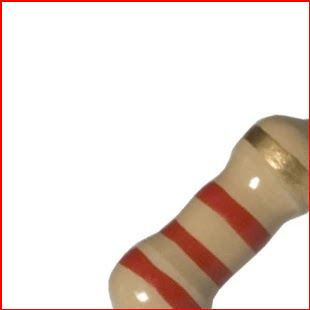

2930 ohm tolerance is +- 1 %


In [ ]:
#debug code
detections = [] #debug resets detections to make sure its fresh

c = Resdetection(dataset[0]) # runs detection

x = find_colours(detections[0]) # gets colours and puts them into 
print(x)


t = resistor_value(x)
print(t)

cv2_imshow(detections[0])
print_values(t)

main code to run whole program

In [ ]:


#ran seperately as this takes the most time
detections = [] # refreshed to makes sure it empties each run
x = 0
for i in dataset:
  Resdetection(i) #  detects resistors


In [ ]:

#detections = [] # refreshed to makes sure it empties each run
#x = 0
#for i in dataset:
#  Resdetection(i) #  detects resistors


x = len(detections)
model = Create_model(x)



redone_images = np.empty([len(dataset), 32, 32, 3], dtype=np.uint8)
# make some fake label values as an example
redone_labels = np.arange(len(dataset))
# convert this 1D array to 2D array
redone_labels = np.expand_dims(redone_labels, axis=1)

for i in range(len(dataset)):
    dim = (32, 32)
    x = cv2.resize(dataset[i], dim)
    redone_images[i, :, :, :] = x


#labels = np.arange(len(dataset))
#labels = np.expand_dims(labels, axis=1)

#datared0 = []
#for i in dataset:
 # dim = (32, 32)
  #datared0.append(cv2.resize(i,dim))

"""
accuracy = model.evaluate(redone_images, redone_labels, verbose = 0)
print(accuracy)
Double_checked = []

for i in range(len(accuracy)) :
  if accuracy[i] > 0.7:
    Double_checked.append(dataset[i])
    print(i)
"""
    #model wasn't detecting more than 1 resistor, though i could have gotten some code wrong


detection_colours = [] # array for resistor colours and location of bands
for i in detections:
  detection_colours.append(find_colours(i))
resistor_vals = [] #stores there values
for i in detection_colours:
  resistor_vals.append(resistor_value(i))

for i in range(len(detections)) :# prints images and there values underneath
  cv2_imshow(detections[i])
  print_values(resistor_vals[i])


Output hidden; open in https://colab.research.google.com to view.

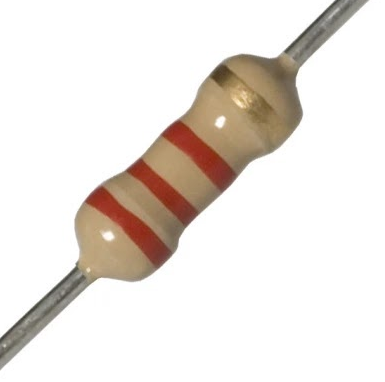

In [ ]:
cv2_imshow(detections[0])